In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
df = pd.read_excel(r'/run/user/1000/gvfs/smb-share:server=10.32.0.81,share=users/Magomedov-az/Documents/sync/region_data.xls',
                  dtype = {'reg_code': np.str})
df.shape

(85, 52)

In [3]:
df.head()

,reg_code,reg_name,area,ЮФО,ПФО,ДВФО,СФО,СКФО,СЗФО,ЦФО,...,min_need,min_need_avg_salary,is_prod_spiriy,vol_prod_spirit,num_producers_spirit,volume_prod_vodka,num_beer_prodecers,vol_of_beer,num_any_producers,volume_any_drink
0,01,Республика Адыгея,ЮФО,1,0,0,0,0,0,0,...,8375,0.373629,0,0.00,1,14624,9,8034,4,5751
1,02,Республика Башкортостан,ПФО,0,1,0,0,0,0,0,...,8623,0.310018,1,629942.76,4,14929,22,170466,9,4710
2,03,Республика Бурятия,ДВФО,0,0,1,0,0,0,0,...,9506,0.375069,0,0.00,0,0,8,58,0,0
3,04,Республика Алтай,СФО,0,0,0,1,0,0,0,...,9435,0.519005,0,0.00,0,0,0,0,1,7
4,05,Республика Дагестан,СКФО,0,0,0,0,1,0,0,...,8708,0.324818,0,0.00,2,83,3,213,13,16593


## Удаляем заведомо аномальные регионы

In [6]:
# Moscow is not Russia
# Drop_Moscow
df.drop(df[df.reg_code == '77'].index, axis=0, inplace=True)
# Drop_SPB
df.drop(df[df.reg_code == '78'].index, axis=0, inplace=True)
# Drop_Sevastopol
df.drop(df[df.reg_code == '92'].index, axis=0, inplace=True)
# Drop Ingushetiya, Dagestan and Chechnya
df.drop(df[df.reg_code == '20'].index, axis=0, inplace=True)
df.drop(df[df.reg_code == '06'].index, axis=0, inplace=True)
df.drop(df[df.reg_code == '05'].index, axis=0, inplace=True)

## Делаем относительные признаки

In [7]:
# Изменение суммы продаж алкоголя 1 полугодия 2018 с тем же 2019
df['index_purch_18_19'] = df['sales_alco_total_2019_1'] / df['sales_alco_total_2018_1']
# Изменение от 1 полугодия в сравнении со вторым
df['index_purch_18_18'] = df['sales_alco_total_2018_2'] / df['sales_alco_total_2018_1']
# число сетевых магазинов к общему числу магазинов
df['rate_of_net_shops'] = df['num_net_shops']/df['num_shops']
# количество людей на 1 алко-магазин
df['shops_on_people'] = df['population']/df['num_shops']
# сумма розничных продаж за 2018г. на население
df['pokup_sposobnost'] = df['retail_total_sale']/df['population']
# Доля расходов на продукты к общим расходам
df['rate_of_food'] = df['retail_food_sale']/df['retail_total_sale']
# расходы на алкогоь к общим розничным расходам
df['total_rate_of_alco'] =  df['sales_alco_total_2019_1']/df['retail_food_sale']
# Доля вина в продажах алкоголя
df['rate_of_vine'] =  df['sales_vine']/df['sales_alco_total_2019_1']
# Доля водки
df['rate_of_vodka'] =  df['consum_vodka_dal']/df['sales_alco_total_2019_1']

## Складываем признаки в группы для удобства

In [8]:
index_data = ['reg_code', 'reg_name', 'area',]
geo_data  = [ 'ЮФО', 'ПФО', 'ДВФО', 'СФО', 'СКФО', 'СЗФО', 'ЦФО', 'УФО']
change_data = ['index_purch_18_19', 'index_purch_18_18']
sales_data = ['rate_of_vodka',  'rate_of_vine', 'rate_of_net_shops', 'shops_on_people']
# rate_of_sity - доля городского населения
# density - плотность населения
# rate_of_wemen - доля женского населения
# rate_of_adult - доля трудоспособного населения
# average_old - средний возраст
demo_data = [ 'rate_of_sity', 'density', 'rate_of_wemen',  'rate_of_adult', 'average_old']
# avg_salary - средняя ЗП
# min_need - прожиточный минимум
# rate_of_food - Доля расходов на продукты к общим расходам
# pokup_sposobnost - сумма розничных продаж за 2018г. на количество людей (млн руб)
# non_jobs - безработица
economic_data = ['avg_salary',  'min_need', 'rate_of_food', 'pokup_sposobnost', 'non_jobs']
# Данные по производству в анализе не использовались
produce_data = ['is_prod_spiriy', 'vol_prod_spirit', 'num_producers_spirit', 'volume_prod_vodka', 'num_beer_prodecers', 
                'vol_of_beer', 'num_any_producers', 'volume_any_drink']

In [15]:
# Набор признаков для регрессии
X = pd.concat([df[sales_data], df[change_data], df[demo_data], df[economic_data], df[produce_data], df[geo_data]], axis=1)
# Целевая переменная - потребление водки на душу
y = df.drink_by_human
len(list(X))

32

## Смотрим отношение признаков к целевой переменной

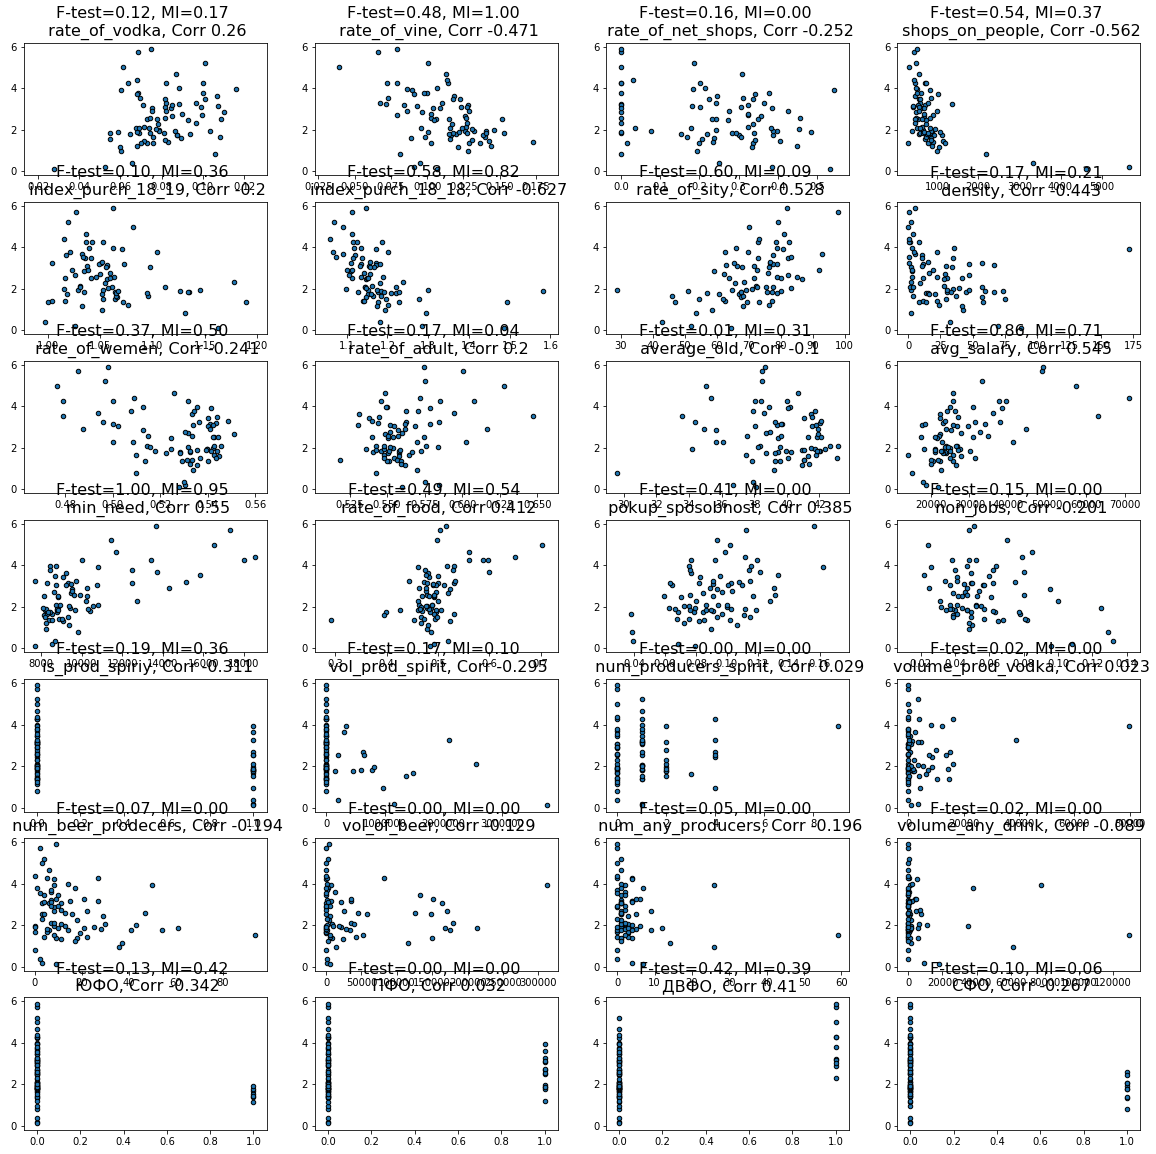

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

plt.figure(figsize=(20, 20))
for i in range(28):
    plt.subplot(7, 4, i + 1)
    plt.scatter(X.iloc[:, i], y, edgecolor='black', s=20)
    plt.title("F-test={:.2f}, MI={:.2f} \n {}, Corr {}".format(f_test[i], mi[i], X.columns[i], 
                                                               y.corr(X.iloc[:, i],'spearman').round(decimals=3)), fontsize=16)
plt.show();

## Смотрим распределение признаков

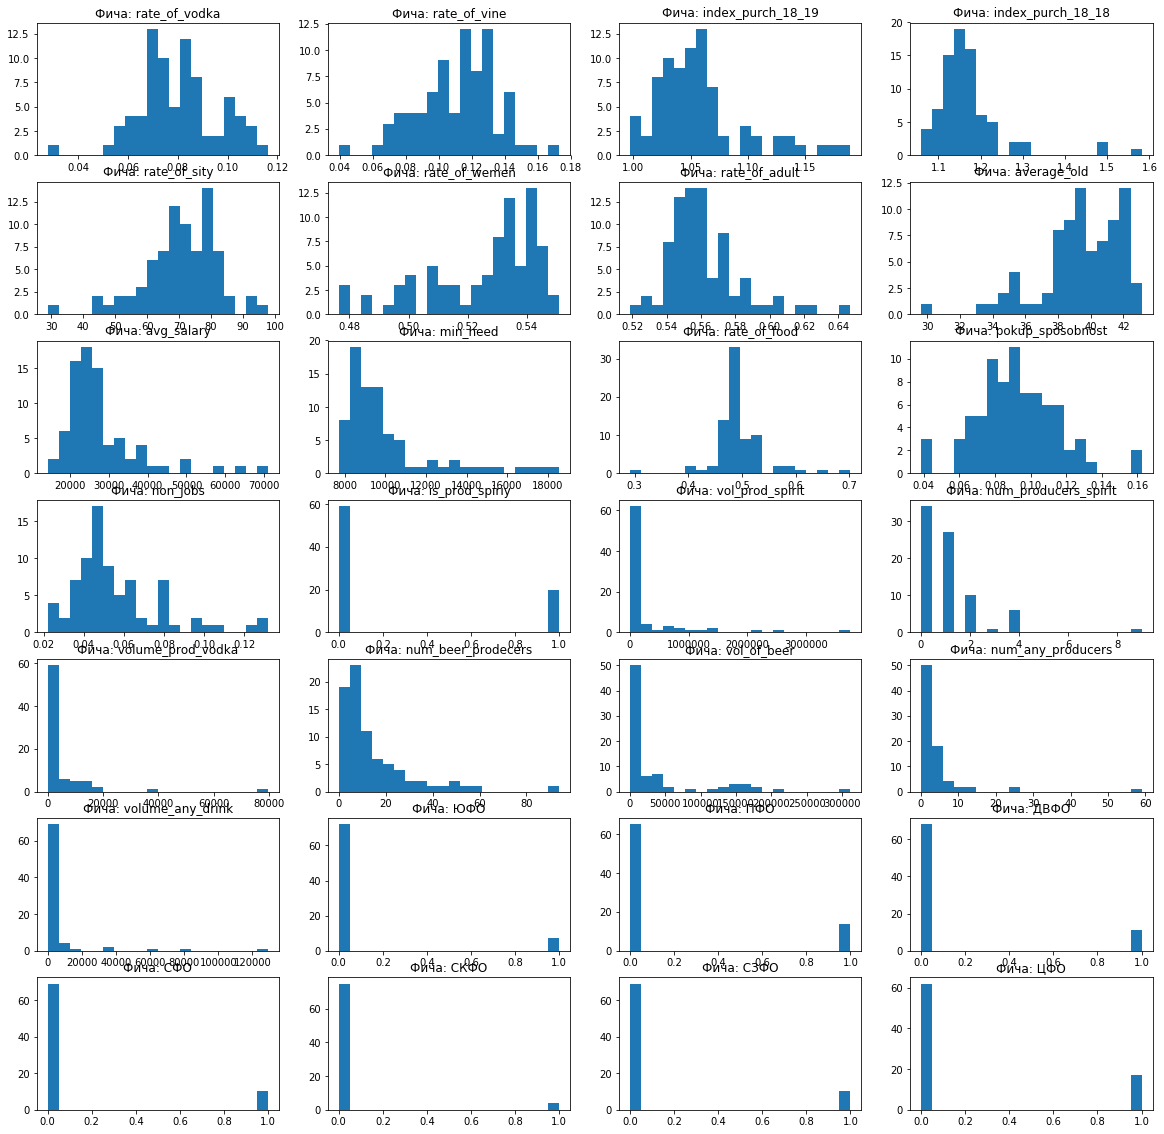

In [32]:
plt.figure(figsize=(20, 20))
for i in range(28):
    plt.subplot(7, 4, i + 1)
    plt.hist(X.iloc[:, i], bins=20)
    plt.title('Фича: {}'.format(X.columns[i]))

### Удаляем бесполезные признаки:

In [12]:
# Бесполезность - это отсутствие корреляции с целевым признаком, и отсутствие у признака объясняющей способности
X.drop(['rate_of_vodka', 'rate_of_wemen', 'index_purch_18_19'], axis=1, inplace=True)

### Преобразуем некоторые признаки

In [21]:
# Доля сетевых магазинов - признак распределен неравномерно, они либо есть и в большом количестве либо их нет в регионе совсем, 
# это может вводить модель в заблуждение, поэтому признак должен быть заменен на бинарный 1 или 0.
X['net_shops'] = X.rate_of_net_shops.apply(lambda x: 1 if x>0.1 else 0)
X.drop(['rate_of_net_shops'], axis=1, inplace=True)
# Плотность населения сиьно скошена, логаримируем признак для равномерности.
X['log_density'] = np.log(X.density)
X.drop(['density'], axis=1, inplace=True)
#  Количество лбдей на магазин
X['log_shops_on_pepole'] = np.log(X.shops_on_people)
X.drop(['shops_on_people'], axis=1, inplace=True)

In [51]:
X.apply(lambda x: x.vol_of_beer=1 if x.vol_of_beer == np.nan) 

SyntaxError: invalid syntax (<ipython-input-51-543d368c8d33>, line 1)

In [12]:
# Нормализация признаков в диапазон от 0 до 1
# X.avg_salary = (X.avg_salary - X.avg_salary.min())/ (X.avg_salary.max() - X.avg_salary.min())
# X.min_need = (X.min_need - X.min_need.min())/ (X.min_need.max() - X.min_need.min())
# X.rate_of_sity = (X.rate_of_sity - X.rate_of_sity.min())/ (X.rate_of_sity.max() - X.rate_of_sity.min())
# X.average_old = (X.average_old - X.average_old.min())/ (X.average_old.max() - X.average_old.min())

In [22]:
X.head()

,rate_of_vodka,rate_of_vine,index_purch_18_19,index_purch_18_18,rate_of_sity,rate_of_wemen,rate_of_adult,average_old,avg_salary,min_need,...,ПФО,ДВФО,СФО,СКФО,СЗФО,ЦФО,УФО,net_shops,log_density,log_shops_on_pepole
0,0.072882,0.102616,1.000488,1.229646,47.02,0.540158,0.551597,39.57,22415.3,8375,...,0,0,0,0,0,0,0,1,4.066631,6.646051
1,0.099632,0.079160,1.050408,1.156385,62.26,0.531769,0.560262,38.75,27814.5,8623,...,1,0,0,0,0,0,0,1,3.344274,6.805672
2,0.110286,0.096796,1.034491,1.111038,59.09,0.512733,0.557092,35.67,25344.7,9506,...,0,1,0,0,0,0,0,0,1.029619,6.192022
3,0.103373,0.126215,1.145363,1.299937,28.88,0.524594,0.535803,34.20,18179.0,9435,...,0,0,1,0,0,0,0,0,0.858662,5.997273
6,0.052546,0.090743,1.026639,1.284824,52.10,0.530412,0.584472,36.72,18766.0,8546,...,0,0,0,1,0,0,0,1,4.240895,8.641004


In [23]:
list(X)

['rate_of_vodka',
 'rate_of_vine',
 'index_purch_18_19',
 'index_purch_18_18',
 'rate_of_sity',
 'rate_of_wemen',
 'rate_of_adult',
 'average_old',
 'avg_salary',
 'min_need',
 'rate_of_food',
 'pokup_sposobnost',
 'non_jobs',
 'is_prod_spiriy',
 'vol_prod_spirit',
 'num_producers_spirit',
 'volume_prod_vodka',
 'num_beer_prodecers',
 'vol_of_beer',
 'num_any_producers',
 'volume_any_drink',
 'ЮФО',
 'ПФО',
 'ДВФО',
 'СФО',
 'СКФО',
 'СЗФО',
 'ЦФО',
 'УФО',
 'net_shops',
 'log_density',
 'log_shops_on_pepole']

#  Модель линейной регрессии

In [25]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
from sklearn import metrics

In [24]:
data = pd.concat([X, y], axis=1)

                              OLS Regression Results                              
Dep. Variable:     np.log(drink_by_human)   R-squared:                       0.927
Model:                                OLS   Adj. R-squared:                  0.915
Method:                     Least Squares   F-statistic:                     65.96
Date:                    Wed, 04 Sep 2019   Prob (F-statistic):           1.53e-31
Time:                            11:14:09   Log-Likelihood:                 25.960
No. Observations:                      79   AIC:                            -27.92
Df Residuals:                          67   BIC:                            0.5137
Df Model:                              11                                         
Covariance Type:                      HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

Text(0, 0.5, 'Fact')

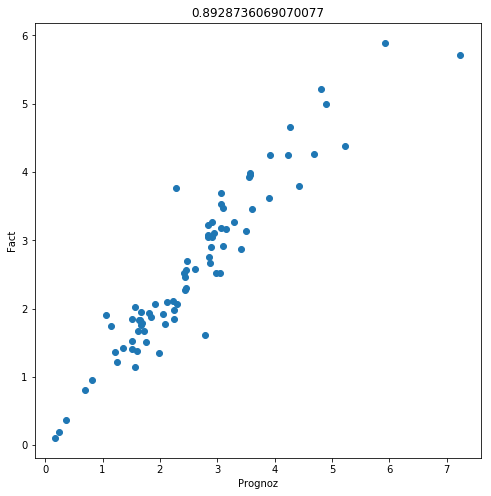

In [50]:
m1 = smf.ols('np.log(drink_by_human) ~  rate_of_vodka + rate_of_vine + index_purch_18_18 + rate_of_sity + '\
             'log_shops_on_pepole +  rate_of_adult + ' \
             ' min_need  + average_old + ' \
             'pokup_sposobnost + log_shops_on_pepole + '\
             'is_prod_spiriy + vol_of_beer ',           
             data=data)
fitted = m1.fit(cov_type='HC1')

print (fitted.summary())

plt.figure(figsize=(8,8))
plt.scatter(np.exp(fitted.predict()), data.drink_by_human)
plt.title(metrics.r2_score(np.exp(fitted.predict()), data.drink_by_human))
plt.xlabel('Prognoz')
plt.ylabel('Fact')

# Качество прогноза модели 82%

### 1. Признаки оказались бесполезными. После их удаления качество прогноза не ухудшается  
##### --- log_density - плотность населения  
##### --- average_old - средний возраст  

### 2. Признаки которые получены из ЕГАИС являются не причиной но следствием искомой величины. То есть не эти признаки объясняют величину потребления на душу а наоборот, объясняются ею.  
##### --- rate_of_vine - доля продаж вина (всего вина)  
##### --- index_purch_18_18 - изменение продаж от 1 полугодия 2018 ко второму  

### Убираем признаки log_density - плотность населения и average_old - средний возраст и безработицу

                              OLS Regression Results                              
Dep. Variable:     np.log(drink_by_human)   R-squared:                       0.885
Model:                                OLS   Adj. R-squared:                  0.870
Method:                     Least Squares   F-statistic:                     47.11
Date:                    Tue, 13 Aug 2019   Prob (F-statistic):           5.33e-26
Time:                            14:22:22   Log-Likelihood:                 8.0824
No. Observations:                      79   AIC:                             3.835
Df Residuals:                          69   BIC:                             27.53
Df Model:                               9                                         
Covariance Type:                      HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

Text(0, 0.5, 'Fact')

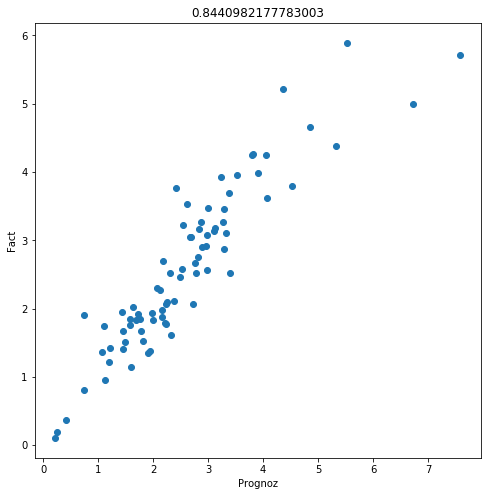

In [14]:
m1 = smf.ols('np.log(drink_by_human) ~  rate_of_vine + index_purch_18_18 + rate_of_sity + '\
             'log_shops_on_pepole +  rate_of_adult + ' \
             ' min_need  + net_shops +  avg_salary + ' \
             'pokup_sposobnost + log_shops_on_pepole',           
             data=data)
fitted = m1.fit(cov_type='HC1')

print (fitted.summary())

plt.figure(figsize=(8,8))
plt.scatter(np.exp(fitted.predict()), data.drink_by_human)
plt.title(metrics.r2_score(np.exp(fitted.predict()), data.drink_by_human))
plt.xlabel('Prognoz')
plt.ylabel('Fact')

##  Качество выросло на 2 %

### Смотрим распределение ошибок прогноза, они должны быть нормально распределены

Populating the interactive namespace from numpy and matplotlib


/home/declar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


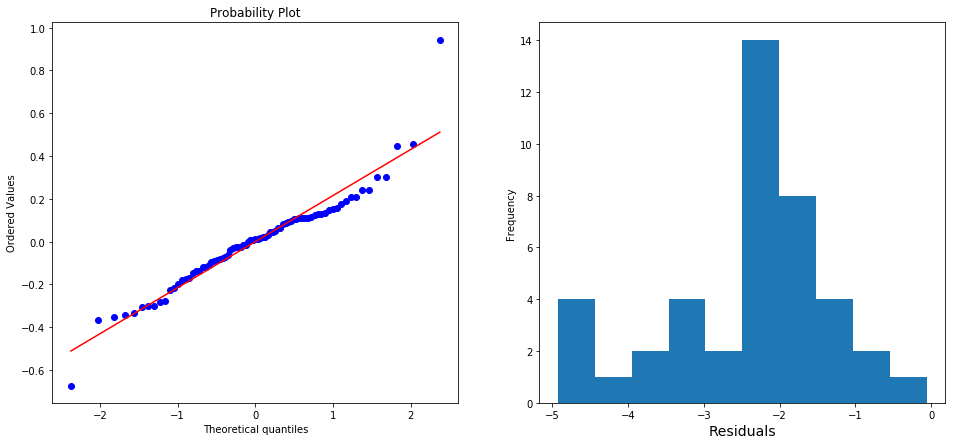

In [33]:
%pylab inline
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show();

## Смотрим выбросы, то есть аномальные по потреблению объекты 

<Figure size 864x864 with 0 Axes>

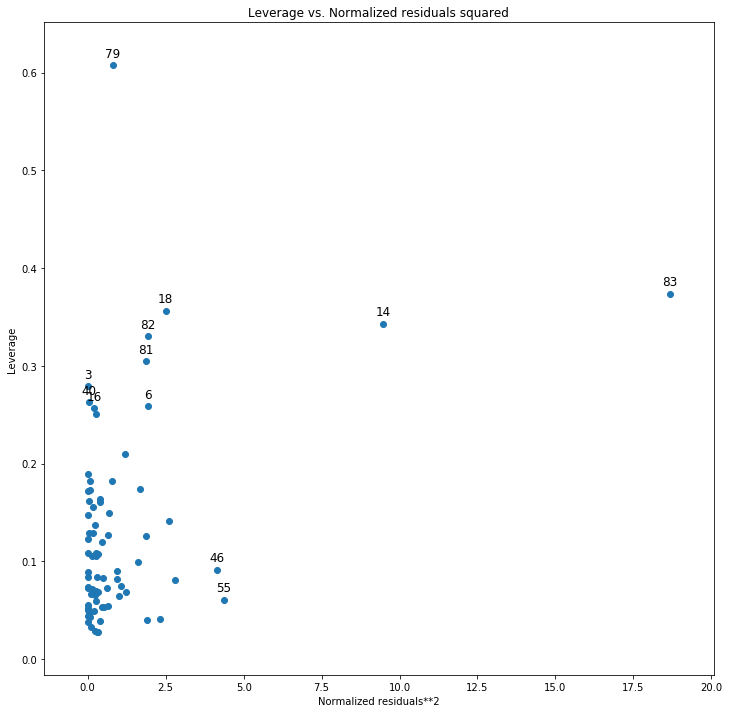

In [34]:
plt.figure(figsize(12,12))
plot_leverage_resid2(fitted)
pylab.show()

In [15]:
anomal_predict = pd.Series(np.exp(fitted.predict(data).loc[[79,83,14,18,82,81,6,3,40,16,46,55]]), name = 'pred')

In [16]:
pd.concat([df[index_data], y, anomal_predict ], axis=1).loc[[79,83,14,18,82,81,6,3,40,16,46,55]]

,reg_code,reg_name,area,drink_by_human,pred
79,83,Ненецкий автономный округ,СЗФО,4.384320,5.335632
83,91,Республика Крым,ЮФО,1.904927,0.741164
14,15,Республика Северная Осетия-Алания,СКФО,0.111663,0.218774
18,19,Республика Хакасия,СФО,1.344641,1.899257
82,89,Ямало-Ненецкий автономный округ,УФО,3.537816,2.611901
81,87,Чукотский автономный округ,ДВФО,4.994362,6.737100
6,07,Кабардино-Балкарская Республика,СКФО,0.191261,0.259375
3,04,Республика Алтай,СФО,1.938752,1.986157
40,41,Камчатский край,ДВФО,4.253996,4.060493
16,17,Республика Тыва,СФО,0.809070,0.733696


## Пробуем построить регрессию без аномальных регионов

In [17]:
new_data = data.drop([79,83,14,18,82,81,6,3,40,16,46,55], axis=0).reset_index()

In [18]:
# pd.concat([df[index_data], df[sales_data], df[demo_data], df[economic_data]], axis=1).loc[[6,83,14,81,79,0,18,82,3,30,60,46]]

                              OLS Regression Results                              
Dep. Variable:     np.log(drink_by_human)   R-squared:                       0.904
Model:                                OLS   Adj. R-squared:                  0.891
Method:                     Least Squares   F-statistic:                     50.61
Date:                    Tue, 13 Aug 2019   Prob (F-statistic):           2.33e-23
Time:                            14:22:44   Log-Likelihood:                 36.198
No. Observations:                      67   AIC:                            -54.40
Df Residuals:                          58   BIC:                            -34.55
Df Model:                               8                                         
Covariance Type:                      HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

Text(0, 0.5, 'Fact')

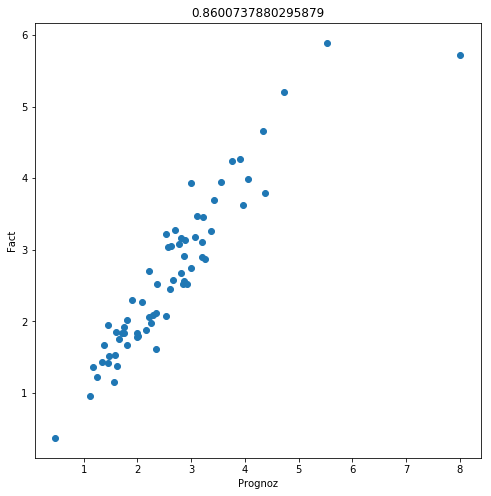

In [19]:
m3 = smf.ols('np.log(drink_by_human) ~  rate_of_vine + index_purch_18_18 + rate_of_sity + '\
             'log_shops_on_pepole +  rate_of_adult + ' \
             ' min_need  + net_shops + ' \
             'pokup_sposobnost + log_shops_on_pepole',             
             data=new_data)
fitted = m3.fit(cov_type='HC1')

print (fitted.summary())

plt.figure(figsize=(8,8))
plt.scatter(np.exp(fitted.predict()), new_data.drink_by_human)
plt.title(metrics.r2_score(np.exp(fitted.predict()), new_data.drink_by_human))
plt.xlabel('Prognoz')
plt.ylabel('Fact')

# Точность прогноза улучшилась. НО! Цель анализа не предсказание потребления а попытка понять норму потребления и как демографические признаки влияют на эту норму.  Поэтому следует исключить признаки, полученные из ЕГАИС а именно - доля вина и изменение продаж между двумя полугодиями 2018 года.

                              OLS Regression Results                              
Dep. Variable:     np.log(drink_by_human)   R-squared:                       0.770
Model:                                OLS   Adj. R-squared:                  0.747
Method:                     Least Squares   F-statistic:                     40.99
Date:                    Tue, 13 Aug 2019   Prob (F-statistic):           1.94e-19
Time:                            14:22:50   Log-Likelihood:                 6.7289
No. Observations:                      67   AIC:                            0.5422
Df Residuals:                          60   BIC:                             15.98
Df Model:                               6                                         
Covariance Type:                      HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

Text(0, 0.5, 'Fact')

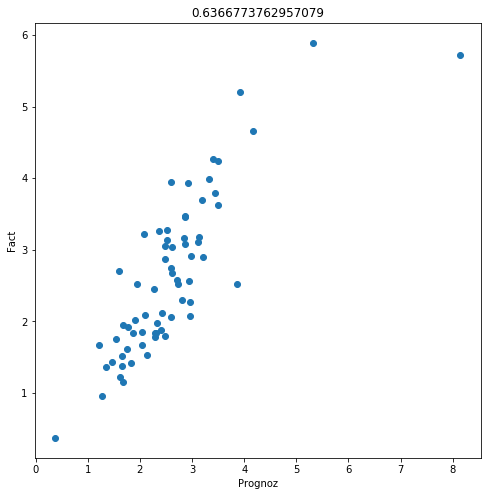

In [20]:
m3 = smf.ols('np.log(drink_by_human) ~  rate_of_sity + '\
             'log_shops_on_pepole +  rate_of_adult + ' \
             ' min_need  + net_shops + ' \
             'pokup_sposobnost + log_shops_on_pepole',             
             data=new_data)
fitted = m3.fit(cov_type='HC1')

print (fitted.summary())

plt.figure(figsize=(8,8))
plt.scatter(np.exp(fitted.predict()), new_data.drink_by_human)
plt.title(metrics.r2_score(np.exp(fitted.predict()), new_data.drink_by_human))
plt.xlabel('Prognoz')
plt.ylabel('Fact')

# Мы сознательно ухудшили качество модели, чтобы понимать, сколько должны потреблять в регионе исходя из социальных данных.

In [21]:
new_df = df.drop([79,83,14,18,82,81,6,3,40,16,46,55], axis=0).reset_index()
new_pred =pd.Series(np.exp(fitted.predict(new_data)), name='new_pred')
result_df = pd.concat([new_df[index_data], new_data, new_pred], axis=1)
result_df[result_df.new_pred > result_df.drink_by_human]

,reg_code,reg_name,area,index,rate_of_vine,index_purch_18_18,rate_of_sity,rate_of_adult,average_old,avg_salary,min_need,rate_of_food,pokup_sposobnost,non_jobs,net_shops,log_density,log_shops_on_pepole,drink_by_human,new_pred
0,01,Республика Адыгея,ЮФО,0,0.102616,1.229646,47.02,0.551597,39.57,22415.3,8375,0.290962,0.102253,0.082,1,4.066631,6.646051,1.372262,1.649463
4,09,Карачаево-Черкесская Республика,СКФО,8,0.095101,1.181003,42.79,0.574967,37.93,17913.2,8667,0.518692,0.039571,0.132,1,3.484619,8.110953,0.374788,0.376089
13,22,Алтайский край,СФО,21,0.119975,1.220694,56.87,0.540817,40.27,21007.8,8798,0.496405,0.068320,0.063,1,2.630449,6.329981,1.778045,2.284955
14,23,Краснодарский край,ЮФО,22,0.115504,1.276695,54.44,0.554405,40.09,31375.9,9349,0.467419,0.115118,0.049,1,4.315219,6.578163,1.526062,2.140467
15,24,Красноярский край,СФО,23,0.095948,1.221250,77.46,0.575980,38.33,26853.7,10799,0.463192,0.094523,0.052,0,0.190620,6.254864,2.070381,2.952384
17,26,Ставропольский край,СКФО,25,0.127844,1.194573,58.56,0.570186,39.21,22675.2,8231,0.478924,0.090042,0.048,1,3.743604,6.904075,0.951537,1.282522
22,31,Белгородская область,ЦФО,30,0.088674,1.146704,67.50,0.558127,41.31,27907.1,8134,0.395174,0.110829,0.039,1,4.043577,6.744898,1.611289,1.745733
23,32,Брянская область,ЦФО,31,0.146110,1.098969,70.90,0.554115,41.48,25082.5,8843,0.467523,0.100334,0.032,1,3.538928,6.508072,1.981379,2.328565
25,34,Волгоградская область,ЮФО,33,0.142543,1.139146,77.38,0.556798,41.08,22000.4,8889,0.472239,0.075408,0.057,1,3.100543,7.037268,1.427723,1.473569
27,36,Воронежская область,ЦФО,35,0.127353,1.177298,67.72,0.557760,42.04,30141.1,8174,0.425678,0.118825,0.040,1,3.797285,6.708271,1.829815,1.859149


In [22]:
result_df.to_excel('/run/user/1000/gvfs/smb-share:server=10.32.0.81,share=users/Magomedov-az/Documents/sync/ols_predict1.xls')

Populating the interactive namespace from numpy and matplotlib


/home/declar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


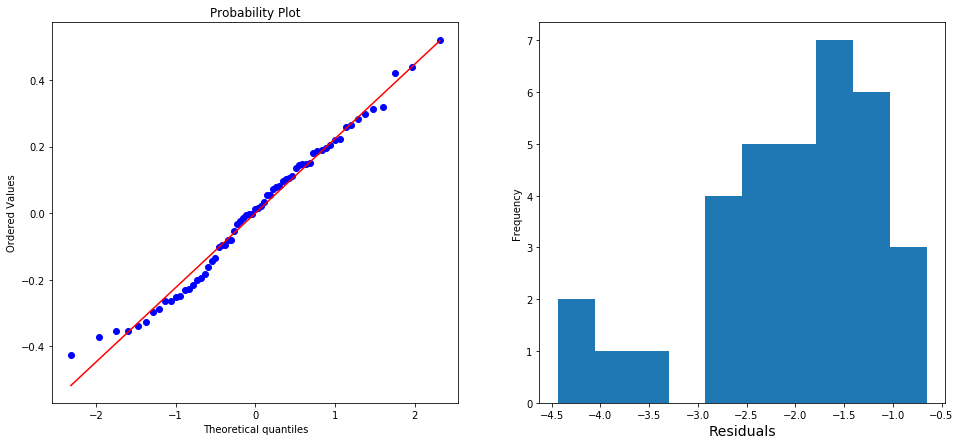

In [50]:
%pylab inline
pylab.figure(figsize(16,7))
pylab.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
pylab.subplot(122)
np.log(fitted.resid).plot.hist()
pylab.xlabel('Residuals', fontsize=14)
pylab.show();

# Кластеризация

## Понижение размерности для визуализации

In [341]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state = 42).fit_transform(X)
X_embedded.shape

(80, 2)

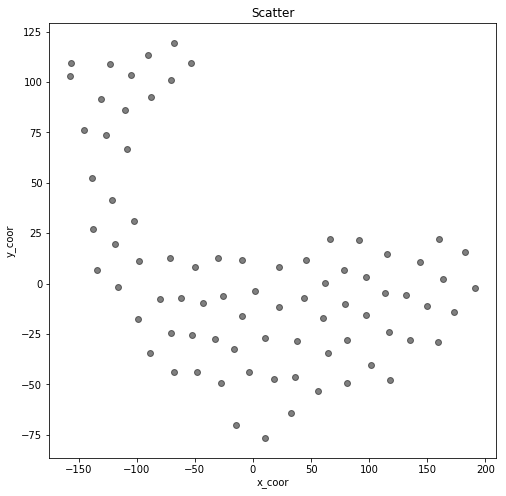

In [342]:
import matplotlib.pyplot as plt
x_coor = X_embedded[:,0]
y_coor = X_embedded[:,1]

plt.figure(figsize=(8,8))
plt.scatter(x_coor, y_coor, c='black', alpha=0.5)
plt.title('Scatter')
plt.xlabel('x_coor')
plt.ylabel('y_coor')
plt.show();

### Для кластеризации регионов надо посмотреть на их расположение относительно друг друга исходя из выбранных признаков

In [343]:
coord = pd.concat([df[index_data].reset_index(), pd.DataFrame(X_embedded).rename(columns={0: 'coor_x', 1: 'coor_y'})], axis=1)
coord.head()

,index,reg_code,reg_name,area,coor_x,coor_y
0,0,01,Республика Адыгея,ЮФО,78.820122,-10.211473
1,1,02,Республика Башкортостан,ПФО,-88.676071,-34.258301
2,2,03,Республика Бурятия,ДВФО,-16.015432,-32.277176
3,3,04,Республика Алтай,СФО,159.599792,-29.209599
4,4,05,Республика Дагестан,СКФО,-67.996254,-43.673744


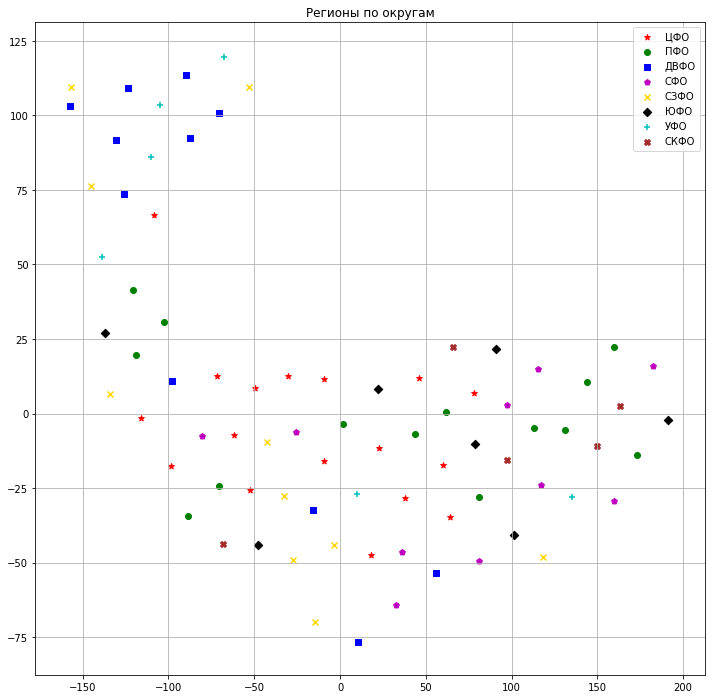

In [345]:
x1 = coord.loc[coord.area=='ЦФО', 'coor_x']
x2 = coord.loc[coord.area=='ПФО', 'coor_x']
x3 = coord.loc[coord.area=='ДВФО', 'coor_x']
x4 = coord.loc[coord.area=='СФО', 'coor_x']
x5 = coord.loc[coord.area=='СЗФО', 'coor_x']
x6 = coord.loc[coord.area=='ЮФО', 'coor_x']
x7 = coord.loc[coord.area=='УФО', 'coor_x']
x8 = coord.loc[coord.area=='СКФО', 'coor_x']

y1 = coord.loc[coord.area=='ЦФО', 'coor_y']
y2 = coord.loc[coord.area=='ПФО', 'coor_y']
y3 = coord.loc[coord.area=='ДВФО', 'coor_y']
y4 = coord.loc[coord.area=='СФО', 'coor_y']
y5 = coord.loc[coord.area=='СЗФО', 'coor_y']
y6 = coord.loc[coord.area=='ЮФО', 'coor_y']
y7 = coord.loc[coord.area=='УФО', 'coor_y']
y8 = coord.loc[coord.area=='СКФО', 'coor_y']

fig, ax = plt.subplots()

# ключ цвета из {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'}:
ax.scatter(x1, y1,  c = 'r', label = 'ЦФО', marker = '*')
ax.scatter(x2, y2, c = 'g', label = 'ПФО', marker = 'o')
ax.scatter(x3, y3,  c = 'b', label = 'ДВФО', marker = 's')
ax.scatter(x4, y4,  c = 'm', label = 'СФО', marker = 'p')
ax.scatter(x5, y5,  c = 'gold', label = 'СЗФО', marker = 'x')
ax.scatter(x6, y6, c = 'k', label = 'ЮФО', marker = 'D')
ax.scatter(x7, y7,  c = 'c', label = 'УФО', marker = '+')
ax.scatter(x8, y8,  c = 'brown', label = 'СКФО', marker = 'X')

ax.grid()
#ax.set_facecolor('black')
ax.set_title('Регионы по округам')
ax.legend(loc="best")

fig.set_figwidth(12)    #  ширина и
fig.set_figheight(12)    #  высота "Figure"

plt.show()

### Кластеризация регионов на округа отчасти себя оправдывает. Дальний Восток, Юг и Кавказ явно отделились, ЦФО размазан по центру. 

### Делаем свою кластеризацию

## K-means

In [349]:
from sklearn import cluster
n_clusters = 5
clasters = cluster.k_means(X, n_clusters, sample_weight=None, init='k-means++', 
                       precompute_distances='auto', 
                       n_init=10, max_iter=300, verbose=False, tol=0.0001, 
                       random_state=42, copy_x=True, n_jobs=-1, algorithm='auto', return_n_iter=False)

In [350]:
coord['number_class'] = list(clasters[-2])
coord['number_class'].value_counts()

1    41
4    17
3    14
0     5
2     3
Name: number_class, dtype: int64

In [354]:
coord[coord['number_class']==4] 

,index,reg_code,reg_name,area,coor_x,coor_y,number_class
3,3,04,Республика Алтай,СФО,159.599792,-29.209599,4
5,6,07,Кабардино-Балкарская Республика,СКФО,150.066269,-10.999881,4
6,7,08,Республика Калмыкия,ЮФО,191.407211,-2.073792,4
7,8,09,Карачаево-Черкесская Республика,СКФО,163.361206,2.491362,4
10,11,12,Республика Марий Эл,ПФО,160.019073,22.281387,4
11,12,13,Республика Мордовия,ПФО,173.298569,-13.961004,4
13,14,15,Республика Северная Осетия-Алания,СКФО,97.340347,-15.601293,4
15,16,17,Республика Тыва,СФО,182.194138,15.810486,4
17,18,19,Республика Хакасия,СФО,116.926575,-23.965334,4
18,20,21,Чувашская Республика,ПФО,143.851105,10.721306,4


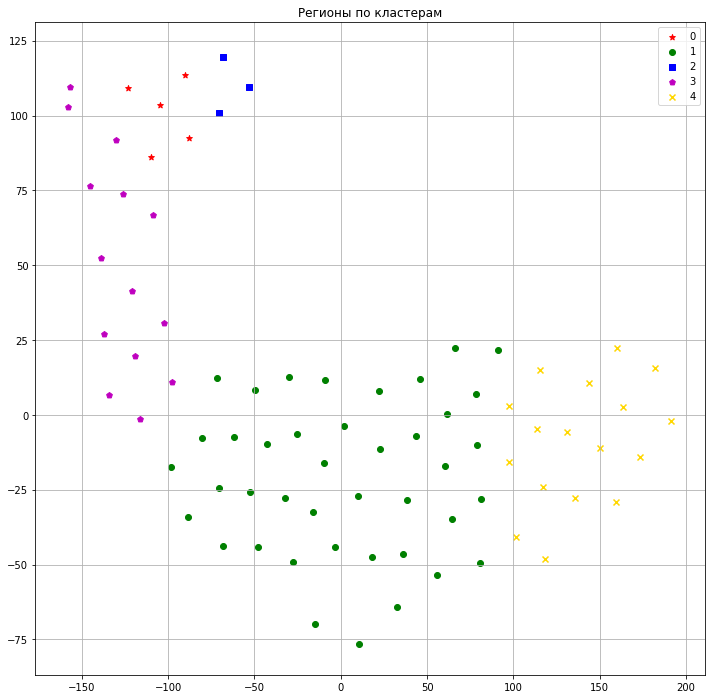

In [355]:
x1 = coord.loc[coord.number_class==0, 'coor_x']
x2 = coord.loc[coord.number_class==1, 'coor_x']
x3 = coord.loc[coord.number_class==2, 'coor_x']
x4 = coord.loc[coord.number_class==3, 'coor_x']
x5 = coord.loc[coord.number_class==4, 'coor_x']

y1 = coord.loc[coord.number_class==0, 'coor_y']
y2 = coord.loc[coord.number_class==1, 'coor_y']
y3 = coord.loc[coord.number_class==2, 'coor_y']
y4 = coord.loc[coord.number_class==3, 'coor_y']
y5 = coord.loc[coord.number_class==4, 'coor_y']

fig, ax = plt.subplots()

# ключ цвета из {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'}:
ax.scatter(x1, y1,  c = 'r', label = 0, marker = '*')
ax.scatter(x2, y2, c = 'g', label = 1, marker = 'o')
ax.scatter(x3, y3,  c = 'b', label = 2, marker = 's')
ax.scatter(x4, y4,  c = 'm', label = 3, marker = 'p')
ax.scatter(x5, y5,  c = 'gold', label = 4, marker = 'x')

ax.grid()
#ax.set_facecolor('black')
ax.set_title('Регионы по кластерам')
ax.legend(loc="best")

fig.set_figwidth(12)    #  ширина и
fig.set_figheight(12)    #  высота "Figure"

plt.show()

## Агломеративная кластеризация

In [363]:
clasters_aglomerate = cluster.AgglomerativeClustering(n_clusters=5, affinity='manhattan', 
                                                      linkage = 'complete').fit(X)

In [364]:
coord['number_class_aglo'] = clasters_aglomerate.labels_
coord['number_class_aglo'].value_counts()

1    58
3    10
2     6
4     3
0     3
Name: number_class_aglo, dtype: int64

In [365]:
coord[coord['number_class_aglo']==2]

,index,reg_code,reg_name,area,coor_x,coor_y,number_class,number_class_aglo
12,13,14,Республика Саха (Якутия),ДВФО,-130.342682,91.704018,3,2
24,26,27,Хабаровский край,ДВФО,-126.155792,73.700386,3,2
38,40,41,Камчатский край,ДВФО,-123.373421,109.149147,0,2
47,49,50,Московская область,ЦФО,-108.486664,66.630432,3,2
48,50,51,Мурманская область,СЗФО,-144.996521,76.448418,3,2
69,71,72,Тюменская область,УФО,-110.078987,86.190048,0,2


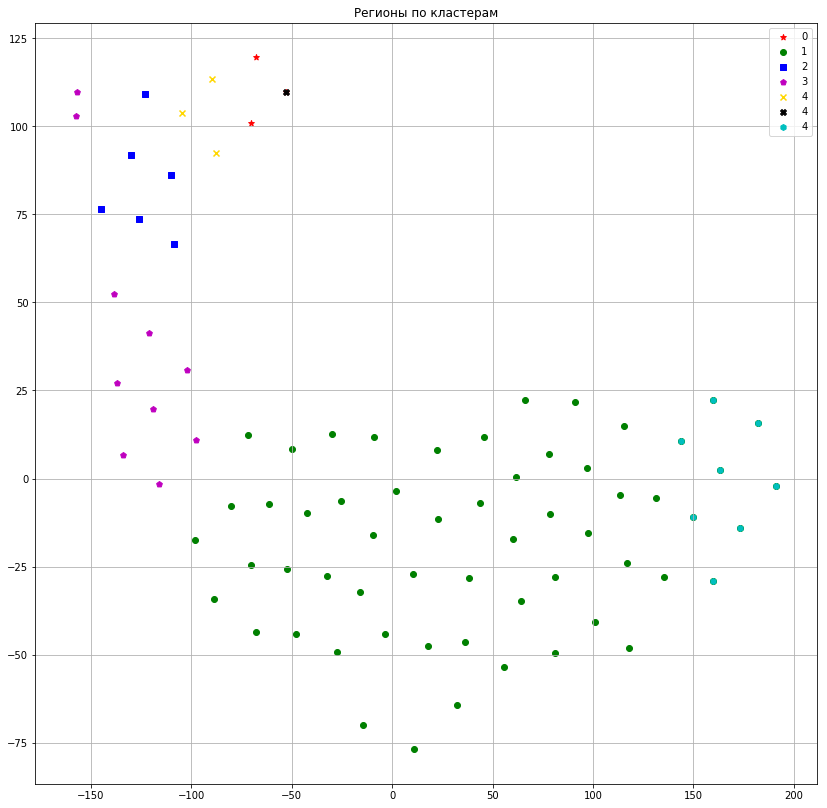

In [366]:
x1 = coord.loc[coord.number_class_aglo==0, 'coor_x']
x2 = coord.loc[coord.number_class_aglo==1, 'coor_x']
x3 = coord.loc[coord.number_class_aglo==2, 'coor_x']
x4 = coord.loc[coord.number_class_aglo==3, 'coor_x']
x5 = coord.loc[coord.number_class_aglo==4, 'coor_x']
# x6 = coord.loc[coord.number_class_aglo==5, 'coor_x']
# x7 = coord.loc[coord.number_class_aglo==6, 'coor_x']


y1 = coord.loc[coord.number_class_aglo==0, 'coor_y']
y2 = coord.loc[coord.number_class_aglo==1, 'coor_y']
y3 = coord.loc[coord.number_class_aglo==2, 'coor_y']
y4 = coord.loc[coord.number_class_aglo==3, 'coor_y']
y5 = coord.loc[coord.number_class_aglo==4, 'coor_y']
# y6 = coord.loc[coord.number_class_aglo==5, 'coor_y']
# y7 = coord.loc[coord.number_class_aglo==6, 'coor_y']

fig, ax = plt.subplots()

# ключ цвета из {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'}:
ax.scatter(x1, y1,  c = 'r', label = 0, marker = '*')
ax.scatter(x2, y2, c = 'g', label = 1, marker = 'o')
ax.scatter(x3, y3,  c = 'b', label = 2, marker = 's')
ax.scatter(x4, y4,  c = 'm', label = 3, marker = 'p')
ax.scatter(x5, y5,  c = 'gold', label = 4, marker = 'x')
# ax.scatter(x6, y6,  c = 'k', label = 4, marker = 'X')
# ax.scatter(x7, y7,  c = 'c', label = 4, marker = 'h')

ax.grid()
#ax.set_facecolor('black')
ax.set_title('Регионы по кластерам')
ax.legend(loc="best")

fig.set_figwidth(14)    #  ширина и
fig.set_figheight(14)    #  высота "Figure"

plt.show()